# Import Dependencies

In [1]:
import tensorflow as tf
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import Callback

# Load Data

In [2]:
data_dir = 'data'

In [3]:
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.2,
    shear_range=0.15,
    zoom_range=0.3,
    fill_mode='nearest',
    horizontal_flip=True,
    validation_split=0.2
)

In [4]:
train_generator = data_gen.flow_from_directory(
    data_dir,
    target_size=(256, 256),
    batch_size=32,
    subset='training',
    shuffle=True
)

Found 1596 images belonging to 5 classes.


In [5]:
val_generator = data_gen.flow_from_directory(
    data_dir,
    target_size=(256, 256),
    batch_size=32,
    subset='validation',
)

Found 397 images belonging to 5 classes.


### Custom Early Stopping to monitor both validation accuracy and validation loss

In [6]:
class CustomEarlyStopping(Callback):
    def __init__(self, monitor_loss='val_loss', monitor_acc='val_accuracy', patience=3):
        super(CustomEarlyStopping, self).__init__()
        self.monitor_loss = monitor_loss
        self.monitor_acc = monitor_acc
        self.patience = patience
        self.best_weights = None
        self.wait = 0
        self.best_loss = np.Inf
        self.best_acc = 0.0
        self.stopped_epoch = 0


    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get(self.monitor_loss)
        current_acc = logs.get(self.monitor_acc)

        if current_loss is None or current_acc is None:
            print(f"Warning: Metric {self.monitor_loss} or {self.monitor_acc} is not available.")
            return

        if current_loss < self.best_loss and current_acc > self.best_acc:
            self.best_loss = current_loss
            self.best_acc = current_acc
            self.best_weights = self.model.get_weights()
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                self.model.set_weights(self.best_weights)
                print(f"Restoring model weights from the best epoch: {epoch + 1 - self.wait}")

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print(f"Epoch {self.stopped_epoch + 1}: early stopping")


In [7]:
custom_early_stopping = CustomEarlyStopping(
    monitor_loss='val_loss',
    monitor_acc='val_accuracy',
    patience=3
)

# Model Architecture

In [8]:
model = Sequential()

In [9]:
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))


In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       147584    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

# Training Model

In [12]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[custom_early_stopping]
)

Epoch 1/50
50/50 [==============================] - 214s 4s/step - loss: 1.7819 - accuracy: 0.2456 - val_loss: 1.4109 - val_accuracy: 0.3123
Epoch 2/50
50/50 [==============================] - 205s 4s/step - loss: 1.3824 - accuracy: 0.3578 - val_loss: 1.2639 - val_accuracy: 0.4307
Epoch 3/50
50/50 [==============================] - 204s 4s/step - loss: 1.3562 - accuracy: 0.4117 - val_loss: 1.2488 - val_accuracy: 0.4811
Epoch 4/50
50/50 [==============================] - 203s 4s/step - loss: 1.2396 - accuracy: 0.4850 - val_loss: 1.1594 - val_accuracy: 0.5441
Epoch 5/50
50/50 [==============================] - 200s 4s/step - loss: 1.1315 - accuracy: 0.5576 - val_loss: 1.0458 - val_accuracy: 0.6247
Epoch 6/50
50/50 [==============================] - 202s 4s/step - loss: 0.9822 - accuracy: 0.6316 - val_loss: 0.9276 - val_accuracy: 0.6348
Epoch 7/50
50/50 [==============================] - 202s 4s/step - loss: 0.9193 - accuracy: 0.6786 - val_loss: 0.9303 - val_accuracy: 0.6700
Epoch 8/50
50

# Graph Visualization

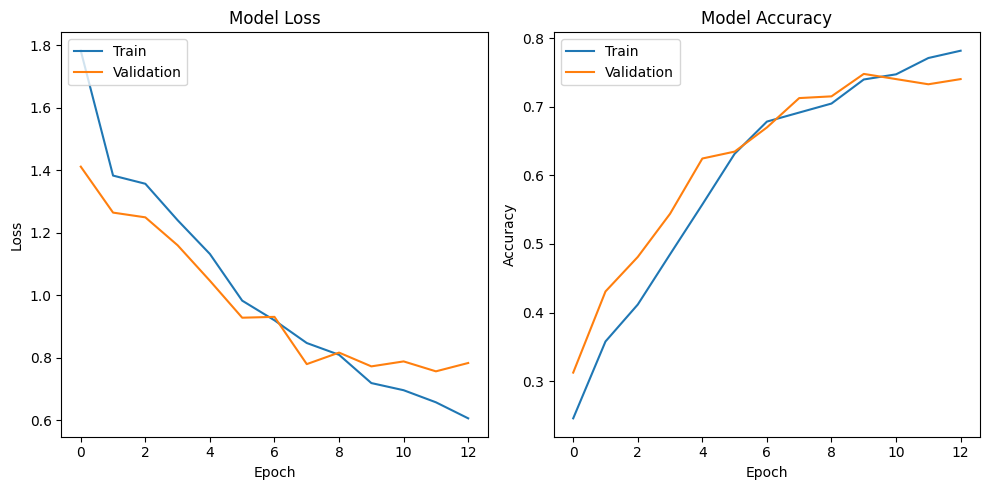

In [13]:
def plot_history(history):
    # To Plot training & validation loss values
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # To Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_history(history)

# Save Model

In [14]:
model.save("foodsv1.keras")

# Testing Model

In [15]:
del model

In [16]:
from tensorflow.keras.models import load_model

model = load_model('foodsv1.keras')

In [17]:
class_names = list(train_generator.class_indices.keys())
class_names

['Burger', 'IceCream', 'Pizza', 'Samosa', 'Sushi']

In [18]:
def preprocess_and_predict_test_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))
    plt.imshow(img)
    img = img / 255
    img = np.expand_dims(img, axis=0)
    pred =  model.predict(img)
    predicted_class_index = np.argmax(pred, axis=1)[0]
    print(f'Predicted class : {class_names[predicted_class_index]}')

1/1 [==============================] - 1s 512ms/step
Predicted class : IceCream


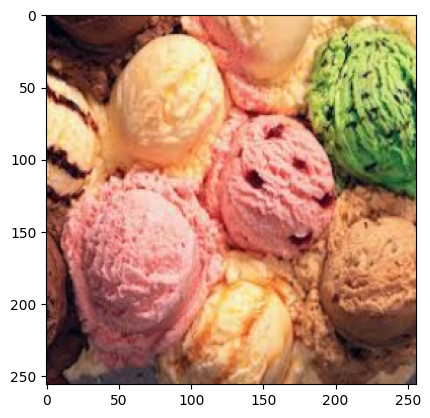

In [19]:
preprocess_and_predict_test_image(r"data\IceCream\ic_82.jpg")

1/1 [==============================] - 0s 49ms/step
Predicted class : Burger


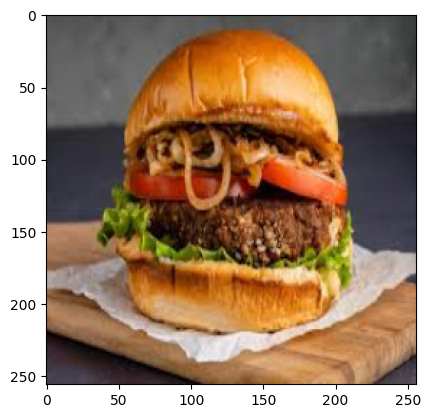

In [20]:
preprocess_and_predict_test_image(r"data\Burger\burger_458.jpg")

1/1 [==============================] - 0s 62ms/step
Predicted class : Pizza


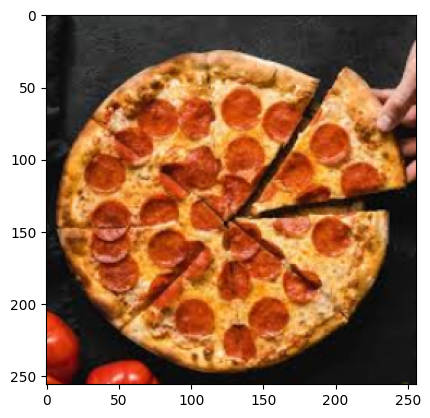

In [21]:
preprocess_and_predict_test_image(r"data\Pizza\test_pizza.jpg")

1/1 [==============================] - 0s 51ms/step
Predicted class : Sushi


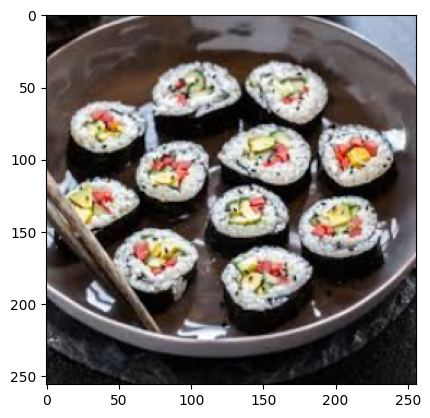

In [22]:
preprocess_and_predict_test_image(r"data\Sushi\test_sushi.jpg")

1/1 [==============================] - 0s 56ms/step
Predicted class : Samosa


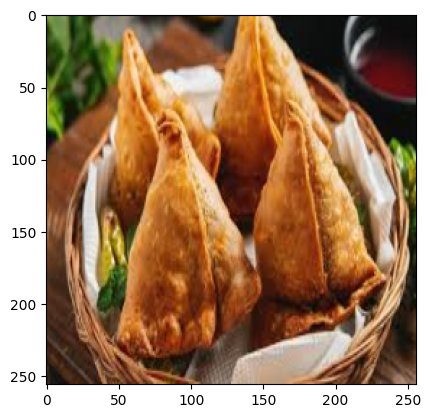

In [23]:
preprocess_and_predict_test_image(r"data\Samosa\test_samosa.jpg")

1/1 [==============================] - 0s 58ms/step
Predicted class : Sushi


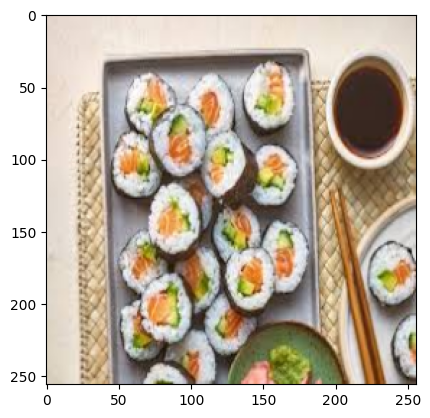

In [24]:
preprocess_and_predict_test_image(r"image.jpeg")